# Question 1

1) Implement a KNN regressor using the scikit-learn conventations

In [6]:
from sklearn.datasets import load_diabetes,fetch_california_housing
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
class KnnRegressor(BaseEstimator):

    def __init__(self, k):
        self.k = k

    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self

    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        m = np.mean(neighbour_labels, axis=1)
        return m

To test your implementation, load the datasets diabetes and california housing through
the functions load diabetes and fetch california housing, both of which are available
in the module sklearn.datasets.

In [7]:
diabetes = load_diabetes()
california = fetch_california_housing()

In [8]:
import numpy as np

def train_test_split(x, y, train_size=0.6, random_state=None):
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    return x[idx_train], x[idx_test], y[idx_train], y[idx_test]

x_train, x_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, train_size=0.6,shuffle=True)
x_train_cali, x_test_cali, y_train_cali, y_test_cali = train_test_split(california.data, california.target, train_size=0.6,shuffle=True)

In [16]:
def error_rate(y, y_hat):
    n = len(y)
    sum_of_errors = sum((y-y_hat)**2)
    return sum_of_errors/n
#finding error rate for diabtes data
knn = KnnRegressor(k=3)
knn.fit(x_train, y_train)
y_hat_train = knn.predict(x_train)
y_hat_test = knn.predict(x_test)
error_rate(y_train, y_hat_train), error_rate(y_test, y_hat_test)

(2352.791614255766, 4318.048336472066)

In [17]:
#finding error rate for california data data
knn = KnnRegressor(k=3)
knn.fit(x_train_cali, y_train_cali)
y_hat_train_cal = knn.predict(x_train_cali)
y_hat_test_cal = knn.predict(x_test_cali)
error_rate(y_train_cali, y_hat_train_cal), error_rate(y_test_cali, y_hat_test_cal)

(0.5716849988297835, 1.2571807930454773)

In [19]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(3)
knn.fit(x_train_cali, y_train_cali)
y_hat_train_cal = knn.predict(x_train_cali)
y_hat_test_cal = knn.predict(x_test_cali)
error_rate(y_train_cali, y_hat_train_cal), error_rate(y_test_cali, y_hat_test_cal)

(0.5716849988297835, 1.2571807930454773)

# Question 2: L - Fold Cross Validation

In [20]:
class LFold:
    def __init__(self, n_splits,shuffle=None): 
        self.n_splits = n_splits
        self.shuffle = shuffle
    def get_n_splits(self, x=None, y=None, groups=None):
        return self.n_splits
    def split(self, x, y=None, groups=None):
        n_samples = np.shape(x)[0]
        indices = np.arange(n_samples)
        if self.shuffle:
            indices = np.random.permutation(indices)
        
        fold_size = n_samples // self.n_splits
        for i in range(self.n_splits):
            start = i * fold_size
            end = (i + 1) * fold_size
            test_idx = indices[start:end]
            train_idx = np.concatenate([indices[:start], indices[end:]])
            yield train_idx, test_idx

In [56]:
for train_idx, test_idx in LFold(5,shuffle=False,random_state=101).split(list(range(22))):
    print(train_idx, test_idx)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [0 1 2 3]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [4 5 6 7]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19 20 21] [ 8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19 20 21] [12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 20 21] [16 17 18 19]


In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def knn_parameter_search(X, y, k_range, n_splits=5):  #defining number of splits
    results = []  #intializing llst
    for k in k_range:
        mse_train = [] #intializing llst
        mse_test = [] #intializing llst 
        lfold = LFold(n_splits=n_splits, shuffle=True)
        for train_idx, test_idx in lfold.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            knn = KnnRegressor(k)    #intializing model
            knn.fit(X_train, y_train)  #fitting model
            y_train_pred = knn.predict(X_train)  #making predictions
            y_test_pred = knn.predict(X_test)   #making predictions
            mse_train.append(mean_squared_error(y_train, y_train_pred))  # calculating the respective mse
            mse_test.append(mean_squared_error(y_test, y_test_pred))
        mean_mse_train = np.mean(mse_train)  #calculating mean mse for each k
        std_mse_train = np.std(mse_train)
        mean_mse_test = np.mean(mse_test)
        std_mse_test = np.std(mse_test)
        results.append({
            'k': k,
            'mean_mse_train': mean_mse_train,
            'std_mse_train': std_mse_train,
            'mean_mse_test': mean_mse_test,
            'std_mse_test': std_mse_test,
            "n_splits" : n_splits
        })
    best_k_result = min(results, key=lambda x: x['mean_mse_test'])   #getting the best mse with the minimum mse error on testing data
    return results, best_k_result

k_range = range(1, 51)
results1, best_k1 = knn_parameter_search(california.data, california.target, k_range, n_splits=5)
print("Best K for dataset 1:", best_k1['k'])
print("Mean Test MSE for best K:", best_k1['mean_mse_test'])
print("Standard Deviation of Test MSE for best K:", best_k1['std_mse_test'])

results2, best_k2 = knn_parameter_search(california.data, california.target, k_range, n_splits=5)
print("Best K for california:", best_k2['k'])
print("Mean Test MSE for best K:", best_k2['mean_mse_test'])
print("Standard Deviation of Test MSE for best K:", best_k2['std_mse_test'])

Best K for dataset 1: 14
Mean Test MSE for best K: 3202.4174628942483
Standard Deviation of Test MSE for best K: 637.5819855519782


The above code uses the self defined code and takes longer to run so another code has been added that using skikitlearn functions which are faster to run

In [25]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

def knn_parameter_search(X, y, k_range, n_splits=5, random_state=None):
    results = []
    for k in k_range:
        mse_train = []
        mse_test = []
        lfold = KFold(n_splits=n_splits, shuffle=True)
        for train_idx, test_idx in lfold.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_train_pred = knn.predict(X_train)  #making predictions
            y_test_pred = knn.predict(X_test)   #making predictions
            mse_train.append(mean_squared_error(y_train, y_train_pred))  # calculating the respective mse
            mse_test.append(mean_squared_error(y_test, y_test_pred))
        mean_mse_train = np.mean(mse_train)  #calculating mean mse for each k
        std_mse_train = np.std(mse_train)
        mean_mse_test = np.mean(mse_test)
        std_mse_test = np.std(mse_test)
        results.append({
            'k': k,
            'mean_mse_train': mean_mse_train,
            'std_mse_train': std_mse_train,
            'mean_mse_test': mean_mse_test,
            'std_mse_test': std_mse_test,
            "n_splits" : n_splits
        })
    best_k_result = min(results, key=lambda x: x['mean_mse_test'])   #getting the best mse with the minimum mse error on testing data
    return results, best_k_result

k_range = range(1, 51)
results1, best_k1 = knn_parameter_search(diabetes.data, diabetes.target, k_range, n_splits=5)
print("Best K for diabetes:", best_k1['k'])
print("Mean Test MSE for best K:", best_k1['mean_mse_test'])
print("Standard Deviation of Test MSE for best K:", best_k1['std_mse_test'])

results2, best_k2 = knn_parameter_search(california.data, california.target, k_range, n_splits=5)
print("Best K for california:", best_k2['k'])
print("Mean Test MSE for best K:", best_k2['mean_mse_test'])
print("Standard Deviation of Test MSE for best K:", best_k2['std_mse_test'])

Best K for diabetes: 16
Mean Test MSE for best K: 3229.696232703173
Standard Deviation of Test MSE for best K: 444.0201696115252
Best K for california: 7
Mean Test MSE for best K: 1.1132086274557107
Standard Deviation of Test MSE for best K: 0.01825456048460864


In [101]:
results1

[{'k': 1,
  'mean_mse_train': 0.0,
  'std_mse_train': 0.0,
  'mean_mse_test': 6232.713636363636,
  'std_mse_test': 1571.6054026216589},
 {'k': 2,
  'mean_mse_train': 1487.481638418079,
  'std_mse_train': 118.8184009438168,
  'mean_mse_test': 4520.620454545455,
  'std_mse_test': 685.7386721065043},
 {'k': 3,
  'mean_mse_train': 2033.5202762084118,
  'std_mse_train': 101.8831684210057,
  'mean_mse_test': 3869.246212121213,
  'std_mse_test': 320.2069392127664},
 {'k': 4,
  'mean_mse_train': 2289.7313559322038,
  'std_mse_train': 74.0212535923737,
  'mean_mse_test': 3749.154403409091,
  'std_mse_test': 421.49362708295365},
 {'k': 5,
  'mean_mse_train': 2433.3196836158195,
  'std_mse_train': 108.66439831157948,
  'mean_mse_test': 3617.356272727273,
  'std_mse_test': 660.2071745702877},
 {'k': 6,
  'mean_mse_train': 2571.5554613935974,
  'std_mse_train': 87.8410786919071,
  'mean_mse_test': 3576.022601010101,
  'std_mse_test': 422.9847423636179},
 {'k': 7,
  'mean_mse_train': 2634.0579153695

The effects of parameter K:
1. Underfitting: When the value of K is really large then the model becomes less flexible and tends to underfit to the data. This is seen when the mean test error is high because the model's perdictions are overly smooth and it fails to capture locak patterns in the data. 
2. Overfitting: When the value of K is very small like 1,2,3 then the model becomes highly sentitive to noise and individual data points which leads to overfitting. This is due to the fact that the model fits the training data too closely resulting in poor generalization to new data. This is evident as the mean test error starts increasing. 

Effects of the parameter L:
1. Low L: When the value of number of folds is small there is less variability in the cross validation procedure. This can reslt in a more stable estimate of the model performance but may have high bias. The error bars which show the standard error of the mean, are narrower which indicates lower uncertainty.
2. High L: With a larger number of folds there is more variance in the cross-validation procedure. This can lead to wider error bars indicating higher uncertainity in the estimated errors. However it provides a more accurate estimate of the model's generalization performance. 

In [26]:
import matplotlib.pyplot as plt
def plot_knn_results(results,l):
    plt.figure(figsize=(16, 8))
    for result in results:
        k_values = result['k']
        mean_mse_train = result['mean_mse_train']
        mean_mse_test = result['mean_mse_test']
        s = result['std_mse_test']
        ste = [1.96 * s / (l ** 0.5)]
        s1 = result['std_mse_train']
        ste1 = [1.96 * s1 / (l ** 0.5)]
        plt.errorbar(
                    k_values, 
                    mean_mse_train, 
                    yerr=ste1, 
                    marker='o',
                    ecolor = 'Red',mfc='red',
         mec='green')
        plt.errorbar(
                    k_values, 
                    mean_mse_test, 
                    yerr=ste, 
                    marker='o',
                    ecolor = 'black',mfc='blue',
         mec='orange')
    plt.title(f'Mean Training and Test Errors')
    plt.xlabel('K Value')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.show()

No handles with labels found to put in legend.


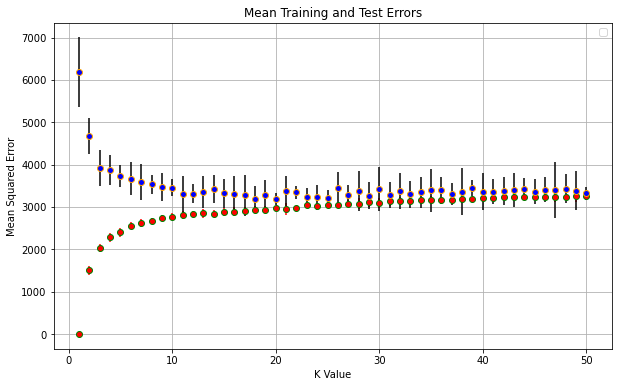

No handles with labels found to put in legend.


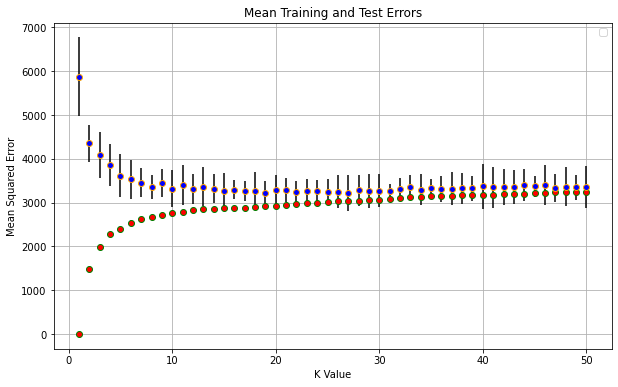

No handles with labels found to put in legend.


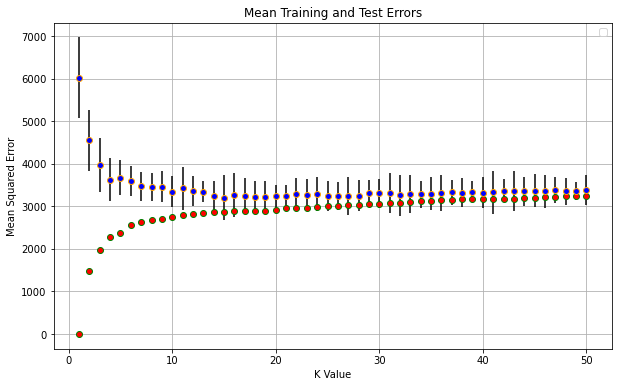

In [34]:
l_values = [5,10,15]
for l in l_values:
    results1, best_k1 = knn_parameter_search(diabetes.data, diabetes.target, k_range, n_splits=l)
    plot_knn_results(results1, dataset_name="diabetes data", l=l)

No handles with labels found to put in legend.


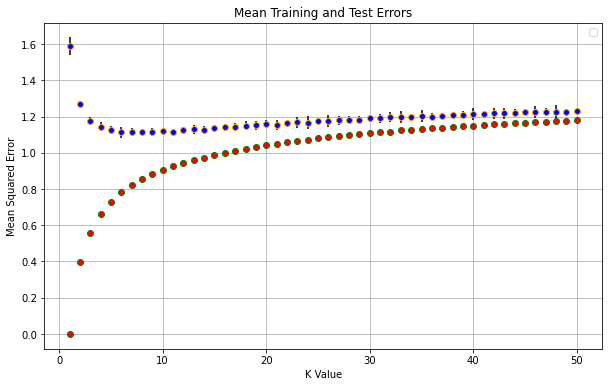

No handles with labels found to put in legend.


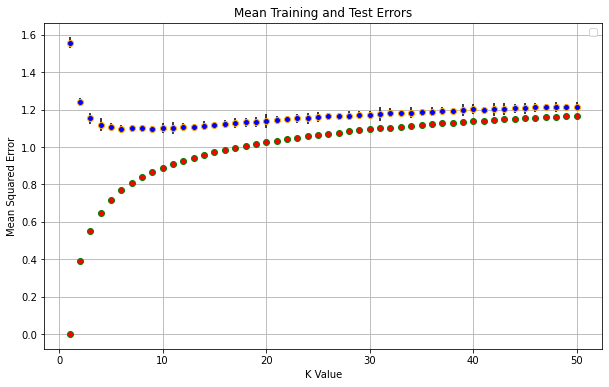

In [46]:
l_values = [5,10]
for l in l_values:
    results2, best_k2 = knn_parameter_search(california.data, california.target, k_range, n_splits=l)
    plot_knn_results(results2, dataset_name="california data", l=l)

# Question 3 Nested CV

In [37]:
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=KFold(5)):
        self.ks = ks
        self.cv = cv
        self.best_k_ = None
        self.model_ = None
        
    def fit(self, X, y):
        best_score = float('-inf')
        for ki in self.ks:
            knn = KNeighborsRegressor(n_neighbors=ki)
            scores = cross_val_score(knn, X, y, cv=self.cv, scoring='neg_mean_squared_error')
            mean_score = scores.mean()
            if mean_score > best_score:
                best_score = mean_score
                self.best_k_ = ki
                
        self.model_ = KNeighborsRegressor(n_neighbors=self.best_k_)
        self.model_.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model_.predict(X)

In [38]:
k1 = KnnRegressorCV()

In [40]:
X = diabetes.data
y= diabetes.target

In [41]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

outer_cv = KFold(n_splits=5)  
selected_k_values = []

for train_index, test_index in outer_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn_cv = KnnRegressorCV(ks=list(range(1, 21)), cv=LFold(5)) 
    knn_cv.fit(X_train, y_train)
    selected_k = knn_cv.best_k_
    selected_k_values.append(selected_k)
    y_pred = knn_cv.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error for outer test set: {mse}")

mean_selected_k = sum(selected_k_values) / len(selected_k_values)

print(f"Mean selected K value across outer cross-validation splits: {mean_selected_k}")


Mean squared error for outer test set: 3365.91468997087
Mean squared error for outer test set: 3239.704055052292
Mean squared error for outer test set: 3518.0419823232323
Mean squared error for outer test set: 2848.7391868512113
Mean squared error for outer test set: 3084.4355955678675
Mean selected K value across outer cross-validation splits: 16.6


In [42]:
selected_k_values

[18, 17, 12, 17, 19]

In [43]:
X = california.data
y= california.target

In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

outer_cv = KFold(n_splits=5) 

selected_k_values = []

for train_index, test_index in outer_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn_cv = KnnRegressorCV(ks=list(range(1, 21)), cv=LFold(5))
    knn_cv.fit(X_train, y_train)
    selected_k = knn_cv.best_k_
    selected_k_values.append(selected_k)
    y_pred = knn_cv.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean squared error for outer test set: {mse}")

mean_selected_k = sum(selected_k_values) / len(selected_k_values)
print(f"Mean selected K value across outer cross-validation splits: {mean_selected_k}")


Mean squared error for outer test set: 1.0985673983935011
Mean squared error for outer test set: 1.034657332348302
Mean squared error for outer test set: 1.4045020207720065
Mean squared error for outer test set: 1.1875299594976432
Mean squared error for outer test set: 1.37360032561288
Mean selected K value across outer cross-validation splits: 9.6


In [45]:
selected_k_values

[9, 10, 11, 8, 10]

Factors determine whether the internal cross-validation procedure is successful in approximately selecting the best model
1. Size and Quality of the Dataset: A larger dataset provides more reliable estimates of model performance and it becomes easier to identify the best hyperparameters. High-quality data also contributes to better model selection.

2. Choice of K Range: The range of K values tested in the inner cross-validation loop is critical. If the range is too narrow or doesn't include the true optimal K the procedure may not select the best model.

3. Number of Inner Folds (L in your previous questions): The number of inner cross-validation folds can impact the reliability of hyperparameter selection. Smaller values may result in more variability while larger values increase computational cost.

4. Data Variability: If the dataset is highly variable it may be challenging to find a single optimal K value that works well for all data partitions.

5. Model Complexity: The complexity of the underlying model (e.g., KNN with different K values) can affect the success of the procedure. Simpler models may be less sensitive to hyperparameter choices.

6. Randomness: The outcome of the cross-validation procedure can have an element of randomness due to the random splitting of data into folds. Repeating the process multiple times and observing consistent results can increase confidence in the chosen K value.